# Cleanning notebook 

Let's first call the libraries I'll use : 

In [1]:
data_path = "~/Documents/openclassroom/data/"

# On importe les librairies dont on aura besoin pour ce tp
import numpy as np
import pandas as pd
## plot : 
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [15, 5]
## stat / model : 
from sklearn.model_selection import train_test_split

import itertools as IT

# 1. Import data : <!-- I have decided to extract the data labeled with the french nutriscore, to set a cleanning method and then decide the application I want to propose.  -->

In [21]:
filename = data_path+"en.openfoodfacts.org.products.csv"
# filename = data_path+"openfoodfacts_with_cholesterol.csv"
# df = pd.read_csv(filename,"\t")

## GET INDEX OF NUTRI SCORE IN COLUMNS : 
tmp = pd.read_csv(filename, sep = "\t").iloc[0,:].index
col_index_nutri_score_fr = np.where(tmp.index=="nutrition-score-fr_100g")[0][0]

In [74]:
def valid(chunks):
    for chunk in chunks:
        mask = ~chunk.iloc[:,p].isna().values
        if mask.all():
            yield chunk
        else:
            yield chunk.loc[mask]
            break

chunksize = 10 ** 5
chunks = pd.read_csv(filename, sep = "\t", low_memory=False, chunksize=chunksize, header=None)
df_original = pd.concat(valid(chunks))

In [83]:
df = df_original.drop(0, axis=0)
df.columns = df_original.loc[0,:]
n = df.shape[0]
df.head(3)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
4,0000000000100,http://world-en.openfoodfacts.org/product/0000...,del51,1444572561,2015-10-11T14:09:21Z,1444659212,2015-10-12T14:13:32Z,moutarde au moût de raisin,NaN,NaN,...,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,0000000000949,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1523440813,2018-04-11T10:00:13Z,1565268412,2019-08-08T12:46:52Z,Salade de carottes râpées,NaN,NaN,...,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,0000000001281,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1517830801,2018-02-05T11:40:01Z,1527070794,2018-05-23T10:19:54Z,Tarte noix de coco,NaN,NaN,...,NaN,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The data is huge (65 166 products).
Let's first work on a sample of size 10 000, and then comment this part : 

In [84]:
df = df.sample(10000, replace = False)
df.shape

(10000, 184)

## 1.1 Drop Missing values : 
Let's remove the variables with too much NaN. First, I remove the columns filled with NaNs (there is no information in them). 

Then, I have chosen to keep the 1st quantile value of the number of NaNs in each variables : 
* if the variable has less NaNs than this quantile, I will estimate the missing value with KNN procedure, 
* else, I drop the corresponding column. 

In [85]:
df = df.copy()
## DROP COL FILLED WITH NANs
df = df.loc[:,df.isna().sum(axis=0)<n]
print("There are ", sum(df.isna().sum(axis=0)==n), "variables without any information (all NaNs)")

## DROP COL WITH MORE NANs THAN THE 1st QUANTILE :
nan_repartition = df.isna().sum(axis=0)
# nan_threshold = nan_repartition.quantile(0.25)
nan_threshold = nan_repartition.mean()
print("I drop variables with more than", nan_threshold, "NaNs")
df = df.drop(df.columns[nan_repartition>nan_threshold], axis = 1)
df.describe()

There are  0 variables without any information (all NaNs)
I drop variables with more than 7173.663043478261 NaNs


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,brands,brands_tags,...,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,potassium_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
count,10000,10000,10000,10000,10000,10000,10000,9993,5256,5256,...,9484,10000,10000,10000,7376,7439,3507,9183,9216,10000
unique,10000,10000,105,8805,8805,8764,8764,8832,1607,1500,...,215,1108,1428,1407,691,373,614,404,582,49
top,0036800527768,http://world-en.openfoodfacts.org/product/0030...,org-database-usda,1489078155,2020-04-23T20:46:32Z,1587627242,2020-11-14T15:15:20Z,Ice cream,Kroger,kroger,...,0,0,0,0,0,0,0,0,0,14
freq,1,1,4552,4,4,5,5,35,194,195,...,3333,1504,1142,1142,4064,4791,402,3169,2940,557


## 1.2 Exploration of the different values :

Then, I used the description data in https://world.openfoodfacts.org/data/data-fields.txt, to separate the global data frame into sub-frames. 
Note : to transform the .txt into these lists of variables, I used the bash command : 

    cat data-fields.txt | cut -d " " -f 1 | sed s/://g | sed s/\$/\",/g | sed s/\^/\"/g > data_fields2.txt

In [86]:
# USE BASH cat data-fields.txt | cut -d " " -f 1 | sed s/://g | sed s/\$/\",/g | sed s/\^/\"/g > data_fields2.txt
list_of_characteristics = ["code","url","creator","created_t","created_datetime","last_modified_t",
                           "last_modified_datetime","product_name","generic_name","quantity"]
list_of_tags = ["packaging", "packaging_tags", "brands", "brands_tags", "categories",
                "categories_tags", "categories_fr","origins", "origins_tags","manufacturing_places",
                "manufacturing_places_tags", "labels", "labels_tags", "labels_fr", "emb_codes", 
                "emb_codes_tags", "first_packaging_code_geo", "cities", "cities_tags", 
                "purchase_places", "stores", "countries", "countries_tags", "countries_fr"]
list_of_ingredients = ["ingredients_text", "traces", "traces_tags"]
list_of_misc = ["serving_size", "no_nutriments", "additives_n", "additives", "additives_tags", 
                "ingredients_from_palm_oil_n", "ingredients_from_palm_oil", 
                "ingredients_from_palm_oil_tags", "ingredients_that_may_be_from_palm_oil_n", 
                "ingredients_that_may_be_from_palm_oil", "ingredients_that_may_be_from_palm_oil_tags", 
                "nutrition_grade_fr", "main_category", "main_category_fr", "image_url", 
                "image_small_url"]
list_of_nutri_facts = ["energy_100g","energy-kj_100g","energy-kcal_100g","proteins_100g","casein_100g",
                       "serum-proteins_100g","nucleotides_100g","carbohydrates_100g","sugars_100g",
                       "sucrose_100g","glucose_100g","fructose_100g","lactose_100g","maltose_100g",
                       "maltodextrins_100g","starch_100g","polyols_100g","fat_100g","saturated-fat_100g",
                       "butyric-acid_100g","caproic-acid_100g","caprylic-acid_100g","capric-acid_100g",
                       "lauric-acid_100g","myristic-acid_100g","palmitic-acid_100g","stearic-acid_100g",
                       "arachidic-acid_100g","behenic-acid_100g","lignoceric-acid_100g","cerotic-acid_100g",
                       "montanic-acid_100g","melissic-acid_100g","monounsaturated-fat_100g",
                       "polyunsaturated-fat_100g","omega-3-fat_100g","alpha-linolenic-acid_100g",
                       "eicosapentaenoic-acid_100g","docosahexaenoic-acid_100g","omega-6-fat_100g",
                       "linoleic-acid_100g","arachidonic-acid_100g","gamma-linolenic-acid_100g",
                       "dihomo-gamma-linolenic-acid_100g","omega-9-fat_100g","oleic-acid_100g",
                       "elaidic-acid_100g","gondoic-acid_100g","mead-acid_100g","erucic-acid_100g",
                       "nervonic-acid_100g","trans-fat_100g","cholesterol_100g","fiber_100g","sodium_100g",
                       "alcohol_100g","vitamin-a_100g","vitamin-d_100g","vitamin-e_100g","vitamin-k_100g",
                       "vitamin-c_100g","vitamin-b1_100g","vitamin-b2_100g","vitamin-pp_100g",
                       "vitamin-b6_100g","vitamin-b9_100g","vitamin-b12_100g","biotin_100g",
                       "pantothenic-acid_100g","silica_100g","bicarbonate_100g","potassium_100g",
                       "chloride_100g","calcium_100g","phosphorus_100g","iron_100g","magnesium_100g",
                       "zinc_100g","copper_100g","manganese_100g","fluoride_100g","selenium_100g",
                       "chromium_100g","molybdenum_100g","iodine_100g","caffeine_100g","taurine_100g",
                       "ph_100g","fruits-vegetables-nuts_100g","carbon-footprint_100g",
                       "nutrition-score-fr_100g","nutrition-score-uk_100g"]

# df_caracteristics = df[df.columns.intersection(list_of_characteristics)]
# df_tags = df[df.columns.intersection(list_of_tags)]
# df_ingredients = df[df.columns.intersection(list_of_ingredients)]
# df_misc = df[df.columns.intersection(list_of_misc)]
df_nutri = df[df.columns.intersection(list_of_nutri_facts)]
df_nutri.describe()

,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,potassium_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
count,9958,10000,10000,10000,9261,9353,9997,10000,9484,10000,10000,7376,7439,3507,9183,9216,10000
unique,764,788,1440,944,93,165,2165,1593,215,1108,1407,691,373,614,404,582,49
top,500,2092,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14
freq,341,341,2333,3818,9069,5634,526,1723,3333,1504,1142,4064,4791,402,3169,2940,557


In [179]:
def print_values_from_list_of_var(df_,list_of_var):
    for var in list_of_var : 
        if var in df_.columns:
            print("--",var)
            tmp = df_[df_.columns.intersection([var])]
            var_values = tmp.iloc[(~pd.isna(tmp).values)]
            if len(var_values) < 8:
                print("values = ", var_values.values)
            else :
                print("ex of values = ", 
                      np.array(tmp.iloc[(~pd.isna(tmp).values)].sample(n=8).values).transpose()[0])
        else : 
            print("--", var, " : no data")
            
# list_of_var = list_of_tags
list_of_var = list_of_nutri_facts
print_values_from_list_of_var(df,list_of_var)

-- energy_100g
ex of values =  ['243' '1393' '1941' '121' '1464' '1586' '920' '1569']
-- energy-kj_100g  : no data
-- energy-kcal_100g
ex of values =  ['529' '467' '76' '49' '24' '63' '388' '122']
-- proteins_100g
ex of values =  ['7.89' '25' '5.41' '25' '21.9' '4.8' '3.54' '5']
-- casein_100g  : no data
-- serum-proteins_100g  : no data
-- nucleotides_100g  : no data
-- carbohydrates_100g
ex of values =  ['3.57' '80' '63.16' '5.42' '44.23' '50.88' '10.33' '5.36']
-- sugars_100g
ex of values =  ['73.33' '0' '23.53' '0' '3.57' '4.8' '0' '3.57']
-- sucrose_100g  : no data
-- glucose_100g  : no data
-- fructose_100g  : no data
-- lactose_100g  : no data
-- maltose_100g  : no data
-- maltodextrins_100g  : no data
-- starch_100g  : no data
-- polyols_100g  : no data
-- fat_100g
ex of values =  ['0.2' '32.14' '6' '0.97' '100' '5.34' '3.57' '0']
-- saturated-fat_100g
ex of values =  ['26.83' '0' '0' '3.45' '0' '3.57' '6.25' '7.14']
-- butyric-acid_100g  : no data
-- caproic-acid_100g  : no da

This variable-type analysis allowed me to select the non-relevant variables for my study, such as the dates, or the name of the person that put the product in the database. Let's remove these :

In [292]:
interest_var = pd.Index(["countries","additives_n","ingredients_from_palm_oil_n",
                "ingredients_that_may_be_from_palm_oil_tags"])
interest_var = interest_var.append(df.columns.intersection(list_of_nutri_facts))

data = df[df.columns.intersection(interest_var)].copy()
# data = data.fillna(pd.NA)

In [457]:
### GESTION DES TYPES DANS DATA !!
## STR 
str_var = list_of_characteristics 
str_var += list_of_tags
str_var += list_of_ingredients
str_var += list_of_misc
str_var = data.columns.intersection(str_var)
data[str_var] = data[str_var].astype("str")

## FLOATS (and INTs)
float_var = list_of_nutri_facts
float_var += ["additives_n", "ingredients_from_palm_oil_n", "ingredients_that_may_be_from_palm_oil_tags"]
float_var = data.columns.intersection(float_var)
data[float_var] = data[float_var].astype("float")

## CATEGORY
data["nutrition-score-fr_100g"] = data["nutrition-score-fr_100g"].astype("category")
# data.dtypes

# 1.3 Errors in data :
We need to check if there are : 
* lexical errors
* irregularity error
* Formatage error
* Duplicates
* Outliers

In [303]:
data.head(3)

,countries,additives_n,ingredients_from_palm_oil_n,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,potassium_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
17251,United States,6.0,0.0,54.0000,226.0,0.0,0.0,0.0,0.0,13.7500,13.7500,0.0,0.0,0.015000,0.0,0.0,0.000,0.000,0.0,18.0
64144,United States,2.0,0.0,59.0000,247.0,0.0,0.0,0.0,0.0,17.6500,5.8800,0.0,0.0,1.588000,NaN,NaN,NaN,NaN,NaN,11.0
68783,United States,1.0,0.0,33.3333,139.0,0.0,0.0,0.0,0.0,6.6667,3.3333,0.0,0.0,0.533333,NaN,NaN,0.043,0.033,0.0,5.0


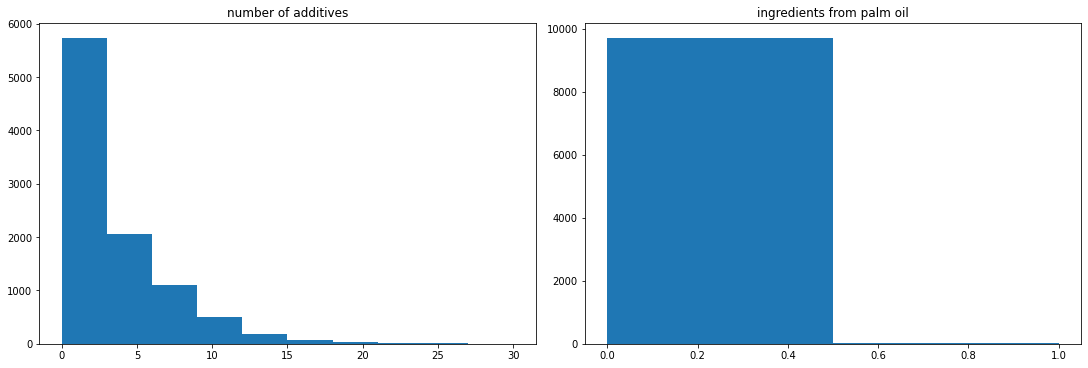

In [421]:
fig, axs = plt.subplots(1,2,constrained_layout=True)

axs[0].hist(data.additives_n)
axs[0].set_title("number of additives")

axs[1].hist(data.ingredients_from_palm_oil_n.values, bins=2)
axs[1].set_title("ingredients from palm oil")
plt.show()

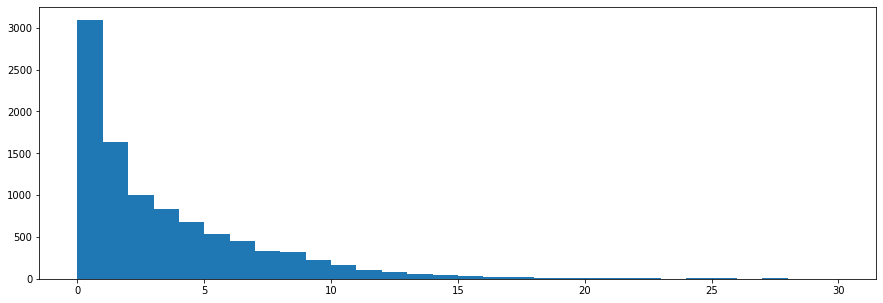

5

In [445]:
nb_bins = min(30, len(np.unique(data[var].values)))

plt.hist(data[var], bins = nb_bins)
plt.show()
nb_line_plot

In [478]:
float_var

Index(['additives_n', 'ingredients_from_palm_oil_n', 'energy-kcal_100g',
       'energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g',
       'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g',
       'potassium_100g', 'calcium_100g', 'iron_100g',
       'nutrition-score-fr_100g'],
      dtype='object', name=0)

In [484]:
for var in float_var :
#     print(np.unique(data[var].dropna().values))
    print(len(np.unique(data[var].dropna().values)),
          min(10, len(np.unique(data[var].dropna().values))),
          max(min(10, len(np.unique(data[var].dropna().values))),30)
    )

28 10 30
2 2 30
764 10 30
788 10 30
1440 10 30
944 10 30
93 10 30
165 10 30
2165 10 30
1593 10 30
215 10 30
1108 10 30
1407 10 30
691 10 30
373 10 30
614 10 30
404 10 30
582 10 30
49 10 30


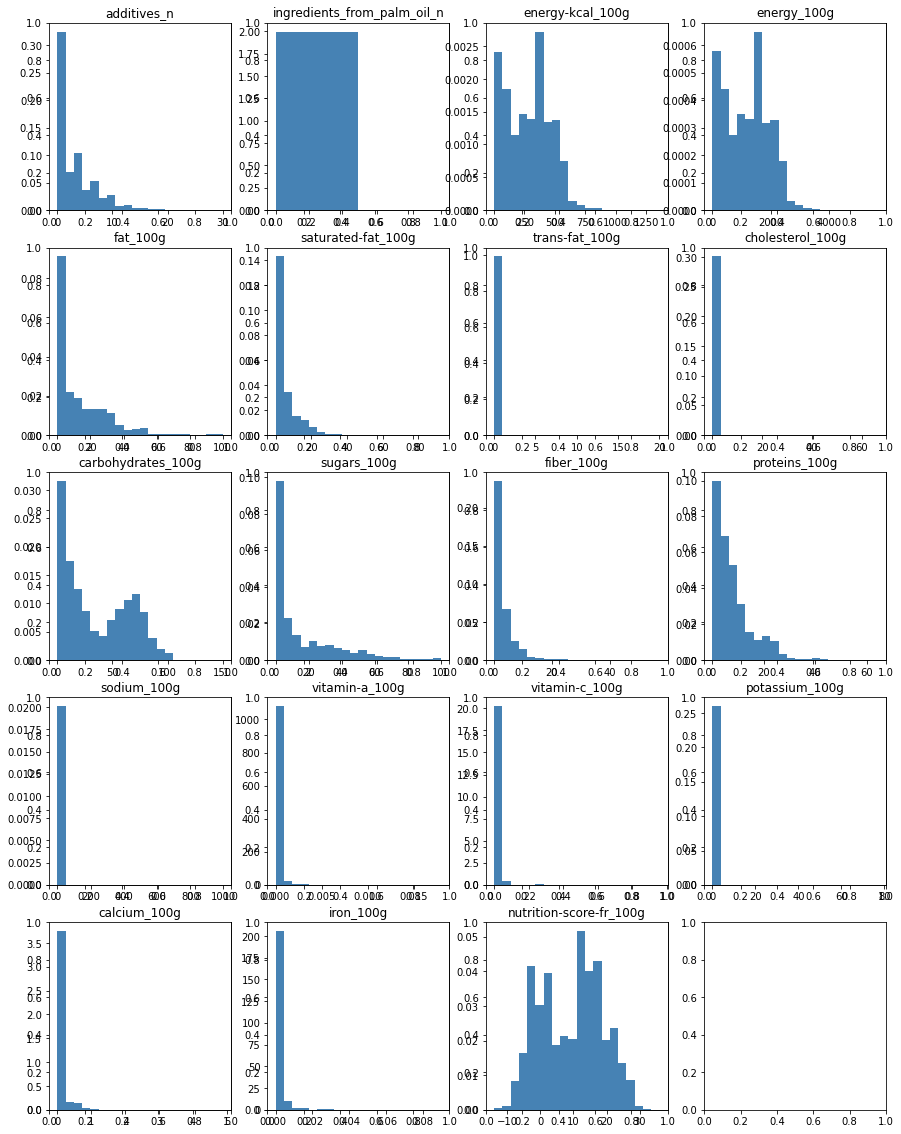

In [487]:
matplotlib.rcParams['figure.figsize'] = [15, 20]
nb_line_plot = int(np.floor(len(float_var)/4)+1)
fig, axs = plt.subplots( 5 , 4)
fig_count = 1
for var in float_var :#data.columns.intersection(list_of_nutri_facts):
    ax = fig.add_subplot(5,4, fig_count)
    nb_bins = min(20, len(np.unique(data[var].dropna().values)))
    ax.hist(data[var], bins = nb_bins, color='steelblue', density=True, edgecolor='none')
    ax.set_title(var)
    fig_count += 1
plt.show()
matplotlib.rcParams['figure.figsize'] = [15, 5]

In [376]:
colname = "additives_n"
possible_values = list(range(35)) # max = 30, if more -> outlier

def extract_irreg_errors(colname,possible_values):
    index_hand_check = []
    col_values = data[colname].drop_duplicates().values
    ## check possible values : 
    for val in col_values :
        if val not in possible_values :
            if ~np.isnan(val):
                val_index = data.iloc[data[colname]==val,:].index
                index_hand_check.append(val_index)
                print(val_index)
            else : 
                print(sum(data[colname].isna()),"missing values")
    return index_hand_check
extract_irreg_errors(colname,possible_values)

287 missing values


[]

In [364]:
# data.iloc[data[colname]==val,:]
data[data[colname]==val]

,countries,additives_n,ingredients_from_palm_oil_n,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,potassium_100g,calcium_100g,iron_100g,nutrition-score-fr_100g


In [367]:
sum(data[colname].isna())

287

In [335]:
data.loc[val_index,:]

,countries,additives_n,ingredients_from_palm_oil_n,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,potassium_100g,calcium_100g,iron_100g,nutrition-score-fr_100g


In [313]:
(data[colname]==np.nan).index

Int64Index([17251, 64144, 68783, 91374, 16136, 23552,  8219, 85089, 52307,
            10268,
            ...
            20542,  7806, 25449, 90812, 65939, 57393, 64753, 15275, 51026,
            26736],
           dtype='int64', length=10000)

In [149]:
## countries VARIABLE TREATMENT (MORE COMPLICATED + TEXT) 
data.countries.drop_duplicates().values[:5]

array(['United States', 'España', 'en:United States', 'France',
       'France, United States'], dtype=object)

# 1.3 Outliers 

Let's deal with outliers

# 1.4 Estimate remaining missing values